In [7]:
import easyocr

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Cleaned Text for Image 1: HR26BR9044


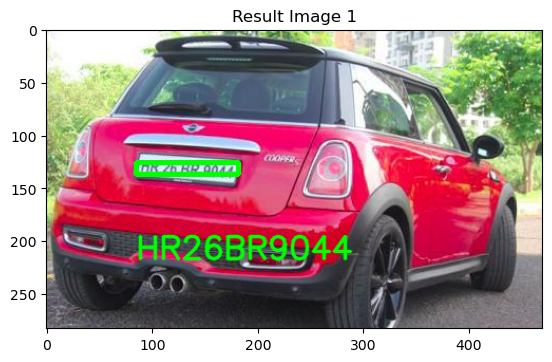

Cleaned Text for Image 2: MH2OCS9817


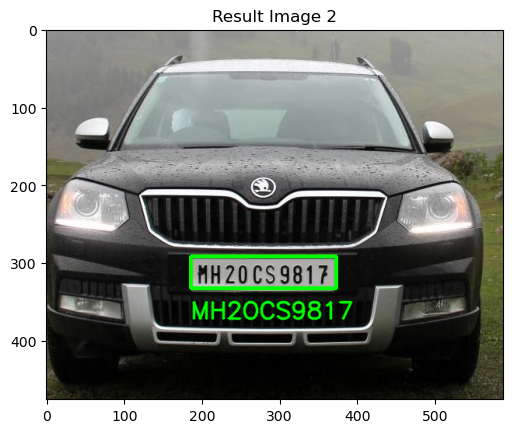

Cleaned Text for Image 3: TN21AT0480


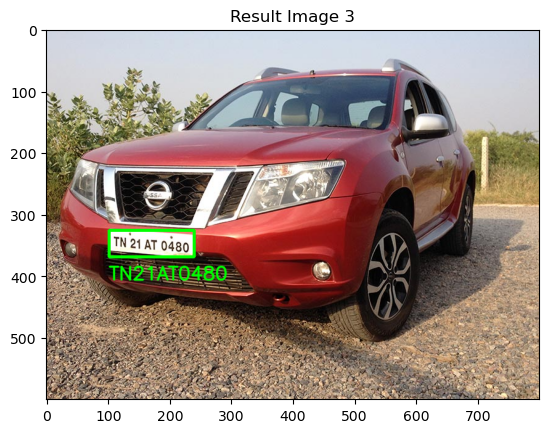

Cleaned Text for Image 4: KL4304444


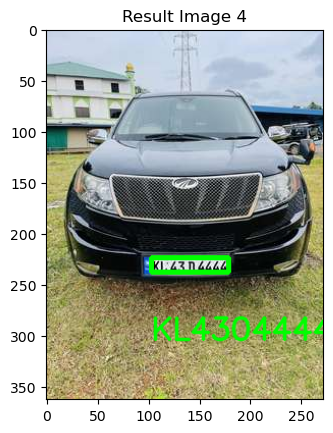

Cleaned Text for Image 5: DLGCAB123X


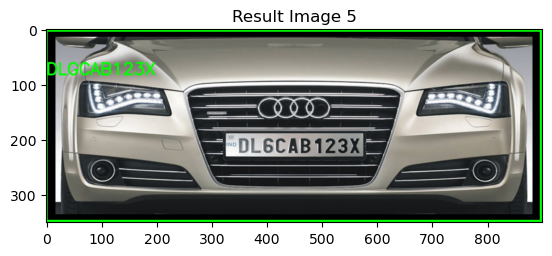

In [21]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import pytesseract
from glob import glob 
# import easyocr

# Load images
paths = glob(r"C:\Users\richu\OneDrive\Pictures\Cars\Test*.jpg")
imgs = [cv2.imread(img) for img in paths]

# Function to preprocess the image: Convert to grayscale, apply filter, and detect edges
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # Noise reduction
    edged = cv2.Canny(bfilter, 30, 200)  # Edge detection
    x1, x2, y1, y2, bbox = detect_number_plate(edged, gray, img)  # Detect the bounding box of the plate
    cropped_image = gray[x1:x2+1, y1:y2+1]  # Crop the region containing the plate
    return cropped_image, bbox

# Function to detect the bounding box of the number plate in the image
def detect_number_plate(edged, gray, img):
    contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  # Sort by area size
    
    bbox = find_bbox(contours)  # Locate the bounding box of the plate
    if bbox is not None:
        mask = np.zeros(gray.shape, np.uint8)  # Create a mask for the detected plate region
        new_image = cv2.drawContours(mask, [bbox], 0, 255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)  # Apply the mask to the original image
        
        (x, y) = np.where(mask == 255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        return x1, x2, y1, y2, bbox
    else:
        print("No bounding box found")
        return 0, 0, 0, 0, None

# Function to find the bounding box around the number plate from the contours
def find_bbox(contours):
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)  # Approximate the contour to a polygon
        if len(approx) == 4:  # Check if the contour has four points (rectangle-like)
            return approx
    return None

# Function to enhance the image for better OCR results
def enhance_image(cropped):
    cropped_resized = cv2.resize(cropped, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(cropped_resized, -1, kernel)
    alpha = 1.5
    beta = 30
    adjusted = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)
    denoised = cv2.bilateralFilter(adjusted, 11, 17, 17)
    return denoised

# OCR function using EasyOCR
reader = easyocr.Reader(['en'])
def extract_text_from_image(cropped):
    enhanced_img = enhance_image(cropped)
    text = reader.readtext(enhanced_img)[0][-2]
    return text

# Run the entire text extraction pipeline
text_results = []
bounding_boxes = []
for img in imgs:
    cropped, bbox = preprocess_image(img)  # Preprocess the image
    text_results.append(extract_text_from_image(cropped))  # Extract text
    bounding_boxes.append(bbox)  # Store bounding box

# Display results with text and bounding box
font = cv2.FONT_HERSHEY_SIMPLEX

for idx, text in enumerate(text_results):
    text = text.replace(" ", "").replace("\n", "").replace("\x0c", "").upper()  # Clean the extracted text
    print(f"Cleaned Text for Image {idx+1}: {text}")
    
    approx = bounding_boxes[idx]  # Get bounding box for current image
    if approx is None:
        print(f"No bounding box for image {idx+1}")
        continue  # Skip if no bounding box
    
    # Ensure approx has the right number of points (4 points expected)
    if len(approx) == 4:
        # Coordinates of the bounding box
        x1, y1 = approx[0][0]
        x2, y2 = approx[2][0]
        
        # Place text on the image at the bounding box location
        res = cv2.putText(imgs[idx], text=text, org=(x1, y1 + 80), 
                          fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
        
        # Draw rectangle around the text (bounding box)
        res = cv2.rectangle(imgs[idx], (x1, y1), (x2, y2), (0, 255, 0), 3)
        
        # Display the final image with text
        plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
        plt.title(f"Result Image {idx+1}")
        plt.show()
    else:
        print(f"Invalid bounding box for image {idx+1}")
